Try gradient-descent training of MPS model on a GHZ state (including rotated bases)

In [1]:
import numpy as np
import torch
from models import MPS, ComplexTensor
import matplotlib.pyplot as plt
from tools import generate_binary_space

In [2]:
#helper function to build unitaries from angles
from qtools import pauli_exp

In [26]:
#system size
L=4
#dimensionality of local hilbert space (2 =qubit)
local_dim =2
#bond dimension of the MPS
bond_dim = 10

Creates uniform, closed-boundary-conditions MPS pure state

In [27]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Load datasets from numpy pickles

In [28]:
samples_fname = "samples_ghz_plus_all_discrete_bases_angles_L=4.npy"
settings_fname = "settings_ghz_plus_all_discrete_bases_angles_L=4.npy"
samples = np.load(samples_fname)
settings = np.load(settings_fname)

Tensors which specify local measurement settings

In [29]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

Tensor holding the corresponding unitaries

In [30]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

Convert samples to binary 0, 1

In [31]:
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)

In [32]:
from torch.utils.data import TensorDataset, DataLoader

In [33]:
class MeasurementDataset(TensorDataset):
    def __init__(self, samples, settings):
        super().__init__()
        if samples.shape[0] != settings.shape[0]:
            raise ValueError
        self.samples = TensorDataset(samples)
        self.settings = TensorDataset(settings)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        samples = self.samples[i][0]
        rot = self.settings[i][0]
        return dict(samples=samples, rotation=dict(real=rot.real,imag=rot.imag))

In [34]:
batch_size = 128
epochs = 5

In [35]:
ds = MeasurementDataset(samples_tr, U)

In [36]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [37]:
lr = .001
optim = torch.optim.Adam(lr=lr,params=psi.parameters())

In [38]:
losses = []
p10 = []
p01 = []
p0 = []
p1 = []

For my curiosity -- record probability assigned to a few basis states during training

In [39]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)
x01 = 1-x10
x0= torch.zeros(1, L,dtype=torch.long)
x1 = torch.ones(1,L,dtype=torch.long)

Train the MPS by minimizing negative-log-likelihood of the observed data.

In [40]:
for n in range(epochs):
    for i,meas in enumerate(dl):
        samples = meas['samples']
        rot = meas['rotation']
        rotation = ComplexTensor(rot['real'], rot['imag'])
        psi.zero_grad()
        loss = psi.nll_loss(samples,rotation=rotation)
        loss.backward()
        optim.step()
        if i%100==0:
            with torch.no_grad():
                losses.append(loss)
                p10.append(psi.prob_normalized(x10))
                p01.append(psi.prob_normalized(x01))
    print("finished epoch %d" %n)

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


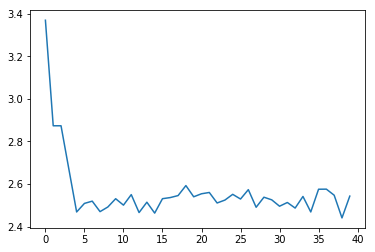

In [41]:
%matplotlib inline
plt.plot(losses)

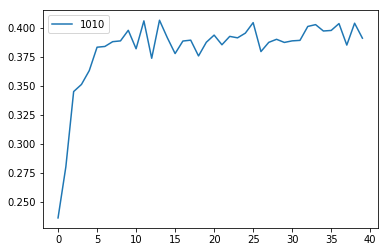

In [42]:
plt.plot(p10, label="1010")
plt.legend()

Look at the probability the trained state assigns to each z-basis state

In [43]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [44]:
with torch.no_grad():
    n = psi.norm().sqrt().item()
    for i in range(len(basis)):
        a = psi.amplitude(basis[i])
        print("{0} has amplitude {1:.4f} + i {2:.4f}, prob {3:.4f}".format(basis[i], 
                                                                            a.real.item()/n, a.imag.item()/n,
                                                                          psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has amplitude 0.0027 + i -0.0063, prob 0.0000
tensor([1, 1, 1, 0]) has amplitude -0.0026 + i 0.0051, prob 0.0000
tensor([1, 1, 0, 1]) has amplitude 0.0024 + i 0.0029, prob 0.0000
tensor([1, 1, 0, 0]) has amplitude -0.0044 + i 0.0063, prob 0.0001
tensor([1, 0, 1, 1]) has amplitude 0.1820 + i 0.0679, prob 0.0377
tensor([1, 0, 1, 0]) has amplitude -0.4121 + i 0.4777, prob 0.3980
tensor([1, 0, 0, 1]) has amplitude -0.1688 + i -0.0368, prob 0.0299
tensor([1, 0, 0, 0]) has amplitude -0.1829 + i -0.0720, prob 0.0386
tensor([0, 1, 1, 1]) has amplitude -0.1822 + i -0.0200, prob 0.0336
tensor([0, 1, 1, 0]) has amplitude -0.1757 + i -0.0530, prob 0.0337
tensor([0, 1, 0, 1]) has amplitude -0.1139 + i -0.6146, prob 0.3907
tensor([0, 1, 0, 0]) has amplitude 0.1910 + i 0.0288, prob 0.0373
tensor([0, 0, 1, 1]) has amplitude -0.0058 + i 0.0057, prob 0.0001
tensor([0, 0, 1, 0]) has amplitude 0.0020 + i 0.0032, prob 0.0000
tensor([0, 0, 0, 1]) has amplitude 0.0090 + i -0.0042, prob 0

In [ ]:
theta = torch.tensor([[np.pi/2]*L])
phi = torch.zeros_like(theta)
U = pauli_exp(theta, phi)

with torch.no_grad():
    n = psi.norm().sqrt().item()
    for i in range(len(basis)):
        a = psi.amplitude(basis[i],rotation=U)
        print("{0} has amplitude {1:.4f} + i {2:.4f}".format(basis[i], a.real.item()/n, a.imag.item()/n))